### Gerekli import işlemlerini gerçekleştirelim

In [1]:
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter



from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier




### Datasetlerimizi inceleyerek kullanıma hazır hale getirelim

In [2]:
column = ['yorum']
df = pd.read_csv('yorumlar.csv', encoding ='iso-8859-9', sep='"')
df.columns=column
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19999 entries, 1 to 19999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   yorum   19999 non-null  object
dtypes: object(1)
memory usage: 312.5+ KB


,yorum
1,Bu filmin katıldığı festivaller ödüllerini fi...
2,çok komik bir film ya izlediğim en iyi komedi...
3,harbiden çooooooook iyiydi herkesin dediği gi...
4,hayaller çok geniştir ve insanlar hayallerini...
5,o kadar sıcak ve samimi bir filmki tebrik etm...


In [3]:
#Yukarıdaki veri setimizin bağımlı değişkenlerini ilk olarak 1 atadık
df['Positivity'] = 1
#Ardından 10003. veriden itibaren negatif yorum içerdiği için 0 olarak değiştirdik
df.Positivity.iloc[10003:] = 0

C:\Users\oztur\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
df.columns = ["Yorum","Duygu"]
df.head()

,Yorum,Duygu
1,Bu filmin katıldığı festivaller ödüllerini fi...,1
2,çok komik bir film ya izlediğim en iyi komedi...,1
3,harbiden çooooooook iyiydi herkesin dediği gi...,1
4,hayaller çok geniştir ve insanlar hayallerini...,1
5,o kadar sıcak ve samimi bir filmki tebrik etm...,1


In [5]:
#2.verisetimizi ekledik
df2 = pd.read_csv("olumsuz.csv")
df2.head()

,Yorum,Duygu
0,çok kötü bir ürün asla tavsiye etmiyoruz,0
1,1 yıl dayanmadı ıdare eder demıcem cunku etmed...,0
2,Eline fazla telefon almayan biri olarak şarjı ...,0
3,5 para etmez,0
4,Telefon konusunda en büyük hatam Vestel güveni...,0


In [6]:
#3. verisetimizi ekledik
df3 = pd.read_excel("comment.xlsx")
# StopWord kelime olarak dahil kabul edilen kelime listesini dahil ettik
stop_word_list = open("stopwords","r").read().split()

In [7]:
# 3. verisetimizde bu çalışma için gerekli olmayan sütünları çıkartıp isimlerini değiştirdik
df3 = df3.drop(columns=["Alışveriş Sitesi","Ürün Adı","Kullanıcı Yorum Puanı                       (1-2-3-4-5)"])
df3.columns=["Yorum","Duygu"]

In [8]:
# verisetindeki değerleri 1 ve 0 olacak şekilde değiştirdik
df3["Duygu"].replace(5.0, value = 2, inplace = True)
df3["Duygu"].replace(1.0, value = 0, inplace = True)
df3["Duygu"].replace(2.0, value = 1, inplace = True)


In [9]:
#3. verisetinde toplamdaki 24055 verinin yanında yer alan çok az sayıda nötr etiketlenmiş verileri çıkarttık
for i in range(4498):
     a = df3["Duygu"][i]
     if a == 3.0:
         df3.drop(i,inplace=True)
    

In [10]:
# veri setindeki değerlendirmesi eksik verileri çıkarttık
df3.dropna(axis = 0,inplace=True)

In [11]:
# tüm verisetlerini birleştirip tek bir veriseti elde ettik
data =pd.concat([df3,df2,df],ignore_index=True)

In [12]:
data.reset_index(drop=True, inplace=True)
duygu = data["Duygu"].astype(int)

In [13]:
data.drop(columns="Duygu",inplace = True)
data = pd.concat([data,duygu],axis = 1)

### Stopword kelimelerin atılması veri setinin kullanılacak hale getirilmesi

In [14]:
#verimizde bulunan noktalama işaretlerinin temizlenme işlemi
data['Yorum'] = data['Yorum'].apply(lambda x: re.sub('[,\.!?();:$%&#"1234567890]', '', x))

#büyük harflerin küçük harfe çevrilmesi
data['Yorum'] = data['Yorum'].apply(lambda x: x.lower())

#fazladan boşlukların temizlenmesi
data['Yorum'] = data['Yorum'].apply(lambda x: x.strip())

#cümleler içerisinde bulunan stopword'lerin kaldırılması
def token(values):
    words = nltk.tokenize.word_tokenize(values)
    filtered_words = [word for word in words if word not in stop_word_list]
    not_stopword_doc = " ".join(filtered_words)
    return not_stopword_doc

data['Yorum'] = data['Yorum'].apply(lambda x: token(x))

In [15]:
data.groupby("Duygu").count()

,Yorum
Duygu,
0,10663
1,13392


### Duygu Sayılarının Görselleştirilmesi

In [17]:
labels = Counter(data['Duygu']).keys()
sum_ = Counter(data['Duygu']).values()
df = pd.DataFrame(zip(labels,sum_), columns = ['sentiment', 'Toplam'])

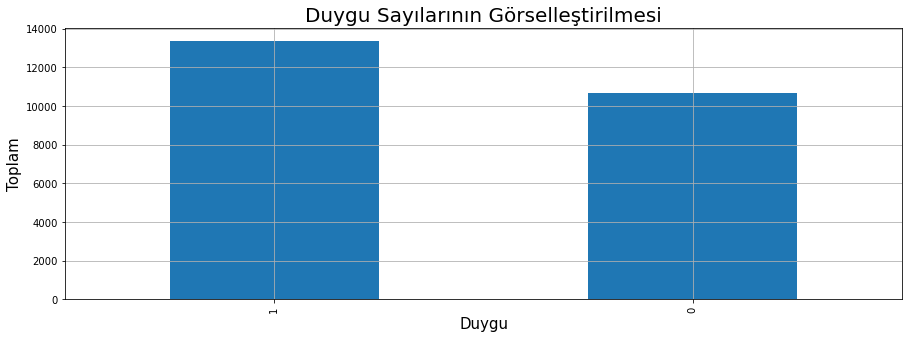

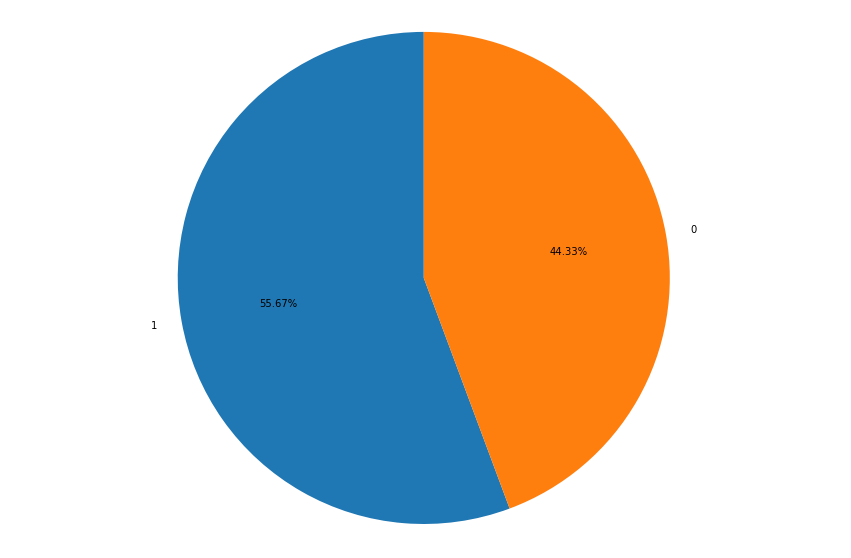

In [18]:

#etiketlerin görselleştirilmesi - çubuk grafiği
df.plot(x = 'sentiment' , y = 'Toplam',kind = 'bar', legend = False, grid = True, figsize = (15,5))
plt.title('Duygu Sayılarının Görselleştirilmesi', fontsize = 20)
plt.xlabel('Duygu', fontsize = 15)
plt.ylabel('Toplam', fontsize = 15);
#etiketlerin görselleştirilmesi - pasta grafiği
fig, ax = plt.subplots(figsize=(15, 10))
ax.pie(df.Toplam, labels =df.sentiment, autopct = '%1.2f%%',  startangle = 90 )
ax.axis('equal')
plt.show()


### Veri setinin TF-IDF metodu ile hazır hale getirilmesi

In [19]:

X_train, X_test, y_train, y_test = train_test_split(data["Yorum"],data["Duygu"], test_size = 0.33,random_state = 0)

In [24]:

vect = TfidfVectorizer().fit(X_train)

X_train_vectorized = vect.transform(X_train)


### Algoritmaların Uygulanması

In [31]:

lr = LogisticRegression()
lr.fit(X_train_vectorized, y_train)
predictions = lr.predict(vect.transform(X_test))
accuarylr= accuracy_score(y_test,predictions)
print(accuarylr)


0.8658521224335559


In [26]:

knn = KNeighborsClassifier(n_neighbors=10,metric="minkowski")

knn.fit(X_train_vectorized, y_train)

y_pred = knn.predict(vect.transform(X_test))
accuaryknn = accuracy_score(y_test,y_pred)
print(accuaryknn)


0.7849855145484318


In [27]:
svc = SVC(kernel = "linear")
svc.fit(X_train_vectorized,y_train)
y_pred = svc.predict(vect.transform(X_test))

accuarysvc = accuracy_score(y_test,y_pred)
print(accuarysvc)

0.8671117269177478


In [28]:
dtc = DecisionTreeClassifier(criterion='gini')

dtc.fit(X_train_vectorized, y_train)
y_pred = dtc.predict(vect.transform(X_test))

accuarydtc = accuracy_score(y_test,y_pred)
print(accuarydtc)

0.758785741277239


In [29]:
rfc = RandomForestClassifier(n_estimators=150,criterion='entropy')

rfc.fit(X_train_vectorized,y_train)
y_pred = rfc.predict(vect.transform(X_test))
accuaryrfc = accuracy_score(y_test,y_pred)
print(accuaryrfc)

0.831338959566696


In [33]:
sgd = OneVsRestClassifier(SGDClassifier(loss = 'hinge', penalty = 'elasticnet', max_iter = 1000))
sgd.fit(X_train_vectorized, y_train)
y_pred = sgd.predict(vect.transform(X_test))
accuarysgd = accuracy_score(y_test,y_pred)
print(accuarysgd)

0.8615694671873032


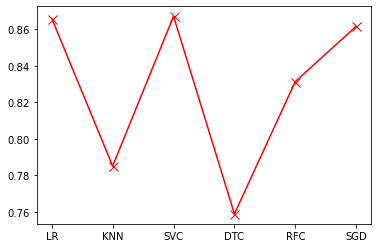

In [34]:
#test accuracy'lerinin görselleştirilmesi
accuracys = [accuarylr,accuaryknn,accuarysvc,accuarydtc,accuaryrfc,accuarysgd]
plt.plot(["LR","KNN", "SVC", "DTC","RFC","SGD"],accuracys , marker = "x" , markersize = 9 , color = "red");

In [78]:
while(True):
    print("Degerlendirme Programına Hoş Geldiniz!!")
    yorum=input("Yorumunuz Nedir?(Programdan çıkmak için \'Q\' yazınız)")
    
    if(yorum == 'Q' or yorum == 'q'):
        break
    else:
        puan = int(input("Degerlendirme Karşılaştırması için 0-1 Puan Değerlendirmede Bulunur musunuz?\n"))
        x =int(sgd.predict(vect.transform([yorum])))
        if x == puan:
            print("Teşekkürler")
            
        else:
            print("Girdiğiniz Puan ve Yorumunuz Eşleşmiyor Tekrar Deneyiniz!!")

Degerlendirme Programına Hoş Geldiniz!!
Yorumunuz Nedir?(Programdan çıkmak için 'Q' yazınız)q
